<a href="https://colab.research.google.com/github/kmshariat/exo_opt/blob/main/TransitParameterOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align = 'center'> Transiting Exoplanet Parameter Optimization</h1>

Author <i> K M Shariat Ullah</i> and <i> Jerome de Leon </i>

In [ ]:
pip install lightkurve

In [ ]:
pip install wotan

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from wotan import flatten
import math

In [ ]:
id = 'TIC 284475976'

The `TransitOverview` function overviews all the light curves for a TIC id.

In [ ]:
def TransitOverview(id):
    datasets = lk.search_lightcurve(id)
    num_datasets = len(datasets)

    if num_datasets == 0:
        print(f"No datasets found for TIC ID {id}.")
        return None

    # Grid
    cols = 5
    rows = math.ceil(num_datasets / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
    axes = axes.flatten()

    # progress bar
    for i in range(num_datasets):
        data_raw = datasets[i].download()
        time_raw = data_raw.time.value
        flux_raw = data_raw.flux.value

        axes[i].scatter(time_raw, flux_raw, color='#363636', marker='.')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Set # {i + 1}")

    # Hide unused axes
    for j in range(num_datasets, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    return fig, num_datasets

In [ ]:
#TransitOverview(id)

In [ ]:
data = lk.search_lightcurve(id)[6].download()
time_real = data.time.value
flux_real = data.flux.value.unmasked
flux_err_real = data.flux_err.value.unmasked

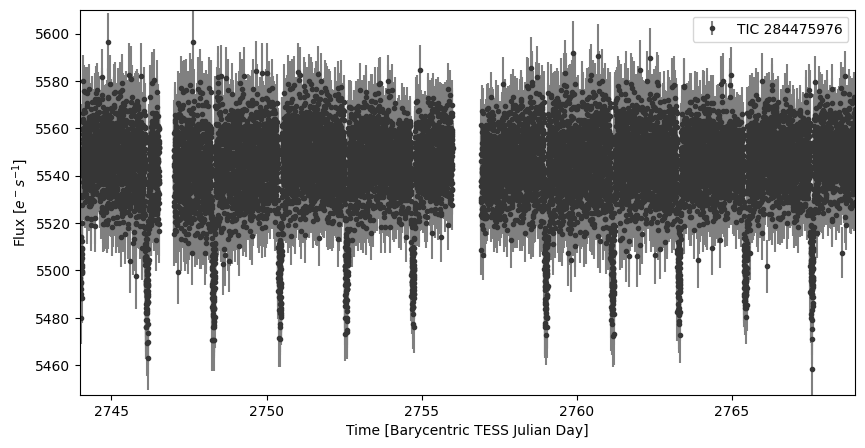

In [ ]:
plt.figure(figsize = (10, 5))
plt.errorbar(time_real, flux_real, flux_err_real, fmt = '.', color = '#363636', ecolor='gray', label = f'{id}')
plt.xlabel('Time [Barycentric TESS Julian Day]')
plt.ylabel('Flux [$e^- s^{-1}$]')
plt.margins(0)
plt.legend()
plt.savefig('Real_Data.png')
plt.show()

Detrending

In [ ]:
flatten_lc, trend_lc = flatten(
    time_real,                 # Array of time values
    flux_real,                 # Array of flux values
    method='biweight',
    window_length=0.75,    # The length of the filter window in units of ``time``
    edge_cutoff=0.5,      # length (in units of time) to be cut off each edge.
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=5.0              # Tuning parameter for the robust estimators
    )

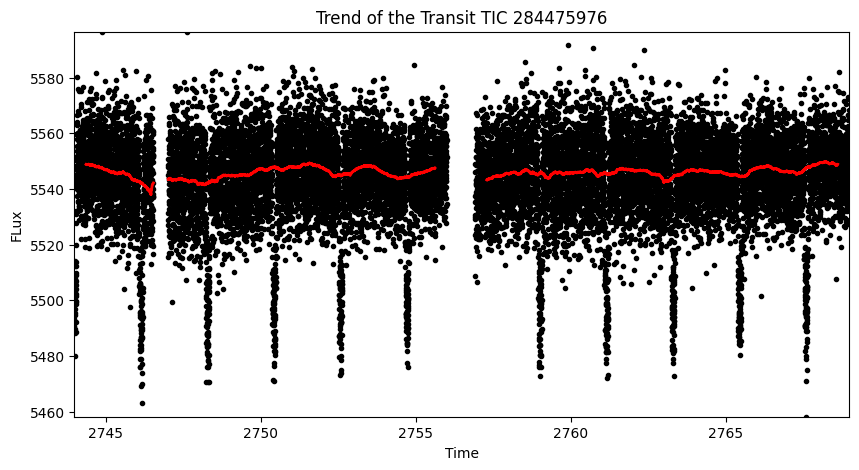

In [ ]:
plt.figure(figsize = (10, 5))
plt.scatter(time_real, flux_real, color='black', marker='.', label = 'Real Data')
plt.plot(time_real, trend_lc, color='red', linewidth=2, label='Trend')
plt.title(f'Trend of the Transit {id}')
plt.xlabel('Time')
plt.ylabel('FLux')
plt.margins(0)
plt.show()

Periodogram

Period at maximum power is: 2.145870344575141
Epoch of the transit is 2746.1372446150467
Transit Duration is 0.1


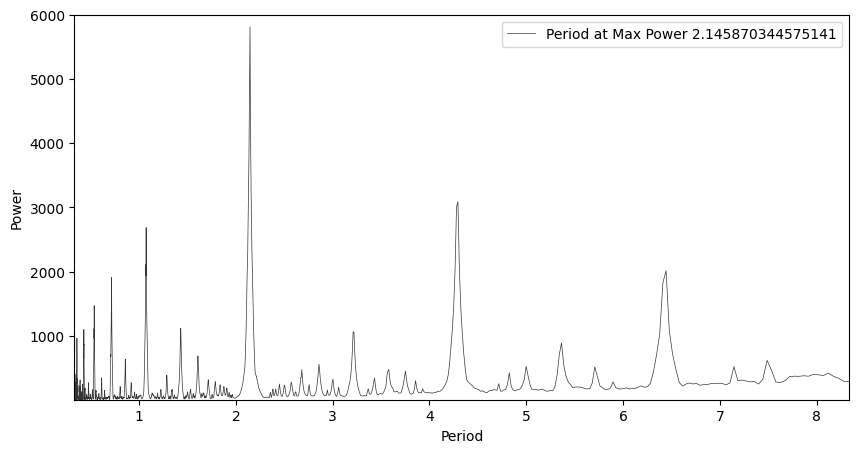

In [ ]:
ls_pg = data.normalize().to_periodogram(maximum_period=8)   # lomb scargle
bls_pg = data.normalize().to_periodogram(method='bls')  # box least square

best_period = bls_pg.period_at_max_power.value
print(f"Period at maximum power is: {best_period}")

t0 = bls_pg.transit_time_at_max_power.value
print(f"Epoch of the transit is {t0}")

t_dur = bls_pg.duration_at_max_power.value
print(f"Transit Duration is {t_dur}")

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(bls_pg.period, bls_pg.power, label=f'Period at Max Power {best_period}', linewidth=0.5, color='#363636')
plt.xlabel('Period')
plt.ylabel('Power')
plt.margins(0)
plt.ylim(top=6000)
plt.legend()
plt.savefig('Periodogram.svg')
plt.show()

Phase Folding

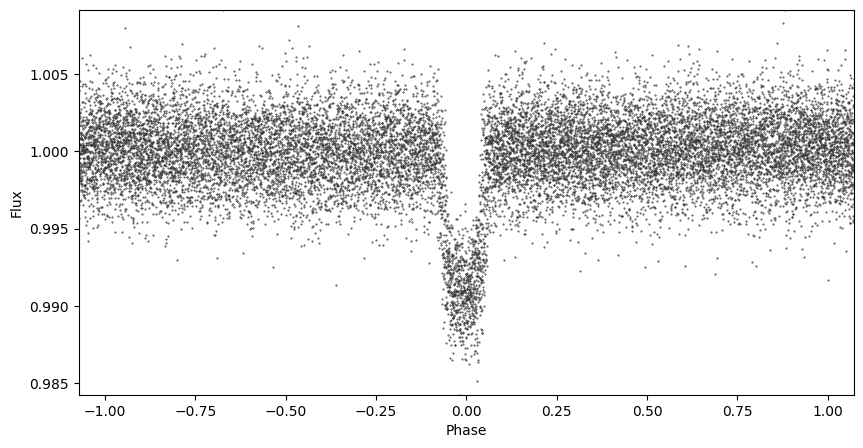

In [ ]:
phase_fold = data.normalize().fold(period=best_period)
phase_folded_time_real = phase_fold.time.value
phase_folded_flux_real = phase_fold.flux.value
plt.figure(figsize=(10,5))
plt.scatter(phase_folded_time_real, phase_folded_flux_real, color='#363636', marker='.', s = 0.75, label = f'Phase Folded Data {id}')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.margins(0)
plt.savefig('PhaseFold.svg')
plt.show()

Mandel-Agol Model Fitting

In [ ]:
!pip install batman-package

In [ ]:
import batman

In [ ]:
params = batman.TransitParams()
params.t0 = t0                       #time of inferior conjunction
params.per = best_period             #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 5.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

In [ ]:
lc_start = time_real[0]
lc_stop = time_real[-1]
time_model = np.linspace(lc_start, lc_stop, len(data))

m = batman.TransitModel(params, time_model)    #initializes model
flux_model = m.light_curve(params)          #calculates light curve

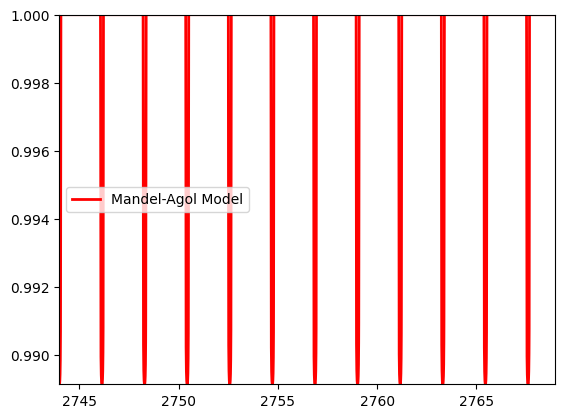

In [ ]:
plt.plot(time_model, flux_model, color='red', linewidth=2, label='Mandel-Agol Model')
plt.legend()
plt.margins(0)
plt.show()

In [ ]:
def phase_fold(t, f, p, t0, e=None):
    """
    Phase fold time and flux arrays in unit of days
    where phase=0=t0
    """
    fold = ((t - t0) % p) / p
    fold[fold > 0.5] -= 1  # Shift to [-0.5, 0.5]
    phase_sort = np.argsort(fold)
    phase_time = fold[phase_sort]
    phase_flux = f[phase_sort]
    if e is not None:
        phase_flux_err = e[phase_sort]
        return phase_time, phase_flux, phase_flux_err
    return phase_time*best_period, phase_flux

In [ ]:
phase_folded_model = phase_fold(t= time_model, f= flux_model, p = best_period, t0=t0)
phase_folded_time_model = phase_folded_model[0]
phase_folded_flux_model = phase_folded_model[1]

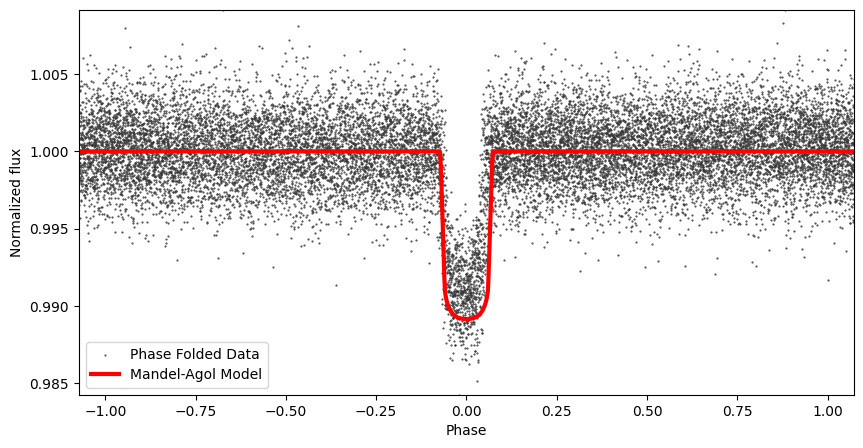

In [ ]:
t = np.linspace(-1, 1, len(phase_folded_time_model))

plt.figure(figsize=(10,5))
plt.xlabel("Phase")
plt.ylabel("Normalized flux")
plt.scatter(phase_folded_time_real, phase_folded_flux_real, color='#363636', marker='.', s = 1, label='Phase Folded Data')
plt.plot(phase_folded_time_model, phase_folded_flux_model, color='red', linewidth=3, label='Mandel-Agol Model')
plt.legend()
plt.margins(0)
plt.show()

In [ ]:
def plot(initial, raw_data):

  lc_start = raw_data[0][0]
  lc_stop = raw_data[0][-1]

  rp, a, i, t0, p, u1, u2 = initial

  params = batman.TransitParams()
  params.t0 = t0                       #time of inferior conjunction
  params.per = p                  #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = a                       #semi-major axis (in units of stellar radii)
  params.inc = i                     #orbital inclination (in degrees)
  params.ecc = 0.                      #eccentricity
  params.w = 90.                       #longitude of periastron (in degrees)
  params.u = [u1, u2]                #limb darkening coefficients [u1, u2]
  params.limb_dark = "quadratic"       #limb darkening model

  plt.figure(figsize=(10,5))
  plt.xlabel("Time from central transit")
  plt.ylabel("Relative flux")

  time_model = np.linspace(lc_start, lc_stop, len(raw_data[0]))

  m = batman.TransitModel(params, time_model)    #initializes model
  flux_model = m.light_curve(params)

  #plt.scatter(raw_data[0], raw_data[1])
  #plt.plot(time_model, flux_model, color='red', linewidth=2, label='Mandel-Agol Model')


  phase_folded_model = phase_fold(t= time_model, f= flux_model, p = p, t0=t0)
  phase_folded_time_model = phase_folded_model[0]
  phase_folded_flux_model = phase_folded_model[1]

  plt.scatter(phase_folded_time_real, phase_folded_flux_real, color='#363636', marker='.', s = 1, label='Phase Folded Data')
  plt.plot(phase_folded_time_model, phase_folded_flux_model, color='red', linewidth=3, label='Mandel-Agol Model')

  plt.legend()
  plt.margins(0)
  plt.show()

Nelder-Mead Optimization

In [ ]:
# clean
d = data[['time','flux','flux_err']].remove_nans().normalize()

In [ ]:
time_clean = d.time.value
flux_clean = d.flux.value.unmasked
flux_err_clean = d.flux_err.value.unmasked

d_clean = (time_clean, flux_clean, flux_err_clean)

In [ ]:
rp = 0.1
a = 5
i = 90
t0 = t0
p = best_period
u1 = 0.1
u2 = 0.3

In [ ]:
initial = [rp, a, i, t0, p, u1, u2]
bounds  = [(0, 1),  #rp
           (1, 100), #a
           (80, 90), #i
           (time_real[0], time_real[-1]), #t0
           (0, 10), #p
           (0, 1), #u1
           (0, 1) #u2
           ]
# phase fold
phase_data = phase_fold(t=np.array(d_clean[0]),
           f=np.array(d_clean[1]),
           p=best_period,
           t0=0,
           e=np.array(d_clean[2]),
           )

raw_data = (d_clean[0], d_clean[1], d_clean[2])

In [ ]:
initial

[0.1, 5, 90, MaskedNDArray(2746.13724462), 2.145870344575141, 0.1, 0.3]

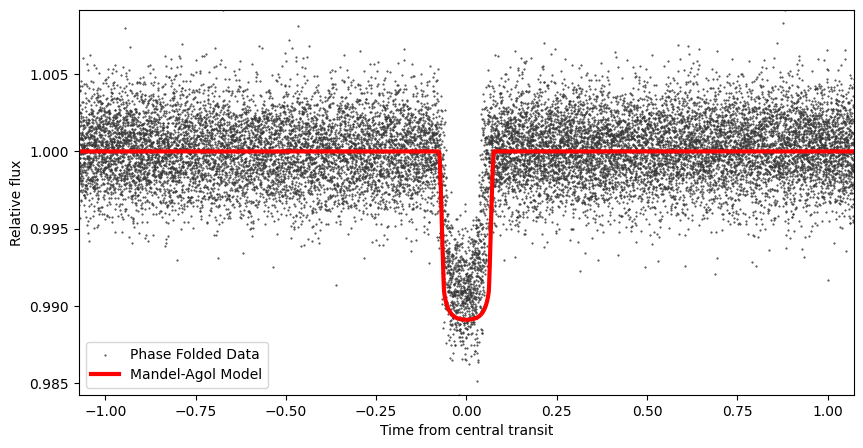

In [ ]:
plot(initial, raw_data)

In [ ]:
def log_likelihood(theta, data):
    """
    Assume Gaussian likelihood function
    theta : model parameters (rp, a, i, t0, p, u1, u2)
    data  : phase-folded time, flux, flux_err
    """
    # phase fold data
    phase_folded_time_real, phase_folded_flux_real, phase_folded_flux_err_real = data
    # unpack free parameters
    rp, a, i, t0, p, u1, u2 = theta
    params = batman.TransitParams()
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"       #limb darkening model
    params.t0 = t0                       #time of inferior conjunction
    params.per = p                      #orbital period
    params.rp = rp                      #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = i                     #orbital inclination (in degrees)
    params.u = [u1, u2]                #limb darkening coefficients [u1, u2]
    # build model
    t_model = np.linspace(lc_start, lc_stop, len(phase_folded_time_real))
    m = batman.TransitModel(params, t_model)    #initializes model
    f_model = m.light_curve(params)


    # # phase fold model
    # phase_model, phase_flux_model = phase_fold(t_model, f_model, p, t0)
    # sigma = np.sqrt(phase_flux_err**2+err**2)
    # return -0.5 * np.sum(np.log(2*np.pi*sigma**2)) * np.sum((phase_flux - phase_flux_model)**2/sigma**2)
    phase_time_model = t_model
    phase_flux_model = f_model
    return -0.5 * np.sum((phase_folded_flux_real - phase_flux_model)**2/phase_folded_flux_err_real**2)


def log_prior(theta):
    """
    Assume uniform prior for all model parameters (rp, a, i, t0, p, u1, u2)
    """
    rp, a, i, t0, p, u1, u2 = theta
    if (bounds[0][0] < rp < bounds[0][1])\
        & (bounds[1][0] < a < bounds[1][1])\
        & (bounds[2][0] < i <= bounds[2][1])\
        & (bounds[3][0] < t0 < bounds[3][1])\
        & (bounds[4][0] < p < bounds[4][1])\
        & (bounds[5][0] < u1 < bounds[5][1])\
        & (bounds[6][0] < u2 < bounds[6][1])\
        & (a*np.cos(np.deg2rad(i)) < 1):
      return 0.0
    return -np.inf


def log_probability(theta, data):
    """
    Mulitply prior and likelihood
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)
nlp = lambda *args: -log_probability(*args)

In [ ]:
# check each component
log_likelihood(initial, raw_data), log_prior(initial), log_probability(initial, raw_data)

(-23823.7619059887, 0.0, -23823.7619059887)

In [ ]:
from scipy.optimize import minimize

In [ ]:
soln = minimize(nlp, initial, method='nelder-mead', args=(raw_data,))

In [ ]:
param_names = ['$r_p$', '$a$', '$i$', '$t_0$', '$p$', '$u_1$', '$u_2$']
if soln.success:
    print("Optimized parameters:")
    for x,param in zip(soln.x, param_names):
        print(f"{param}: {x}")
else:
    print("Optimization unsuccessful!")

Optimized parameters:
$r_p$: 0.04716805088026304
$a$: 7.22463239996763
$i$: 89.84247017548498
$t_0$: 2748.306250913616
$p$: 2.1318513435062347
$u_1$: 0.08713151125530999
$u_2$: 0.3460369890220403


### MCMC Optimization


In [ ]:
pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
pip install corner

In [ ]:
from multiprocessing import Pool
import corner
import emcee

In [ ]:
nparams = len(soln.x) #free parameters
nwalkers = nparams*10
pos = soln.x + 1e-4 * np.random.randn(nwalkers, nparams)

In [ ]:
np.random.randn(nwalkers, nparams).shape

(70, 7)

In [ ]:
# initialize walkers randomly offset around the optimized solution
initial_pos = np.random.randn(nwalkers, nparams) + soln.x + 1e-4
initial_pos[0]

array([2.38579176e+00, 7.36250390e+00, 8.87385157e+01, 2.74951257e+03,
       2.79318155e+00, 1.15991219e-01, 5.61765554e-01])

In [ ]:
raw_data

(array([2743.99724462, 2743.99863353, 2744.00002245, ..., 2768.97686821,
        2768.97825712, 2768.97964604]),
 array([0.9908033 , 0.990592  , 0.99009615, ..., 1.0022694 , 1.0028349 ,
        0.99781984], dtype=float32),
 array([0.00192931, 0.00193013, 0.00192798, ..., 0.00192911, 0.00192973,
        0.00192572], dtype=float32))

In [ ]:
# run mcmc for 1000 steps in parallel using pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, nparams, log_probability, args=(raw_data,), pool=pool)
    sampler.run_mcmc(initial_pos, 2000, progress=True);

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [01:42<00:00, 19.59it/s]


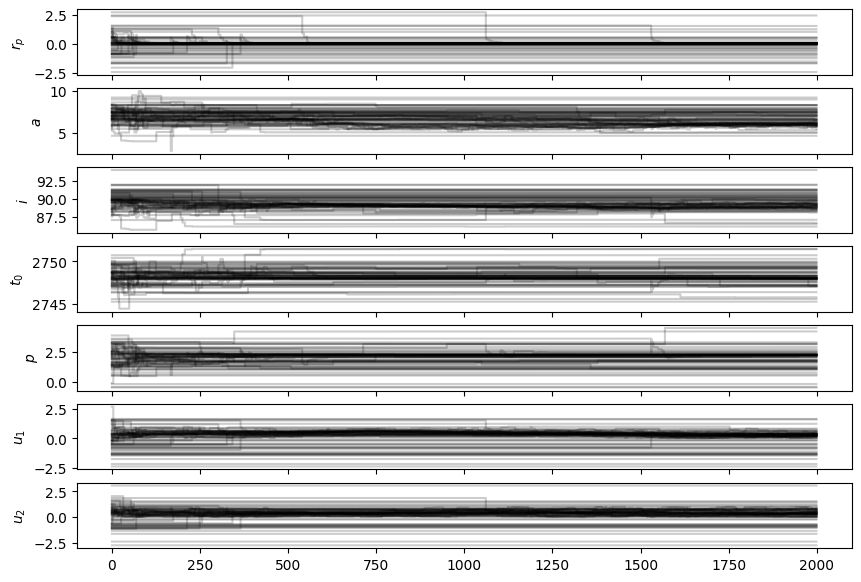

In [ ]:
fig, axs = plt.subplots(nparams, 1, figsize=(10, nparams), sharex=True)
ax = axs.flatten()

for i, history in enumerate(sampler.chain[:,:,:].T):
    ax[i].plot(history, drawstyle='steps', color='k', alpha=0.2)
    ax[i].set_ylabel(param_names[i])


Corner Plot

/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:272: UserWarning: More chains (2000) than draws (70). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


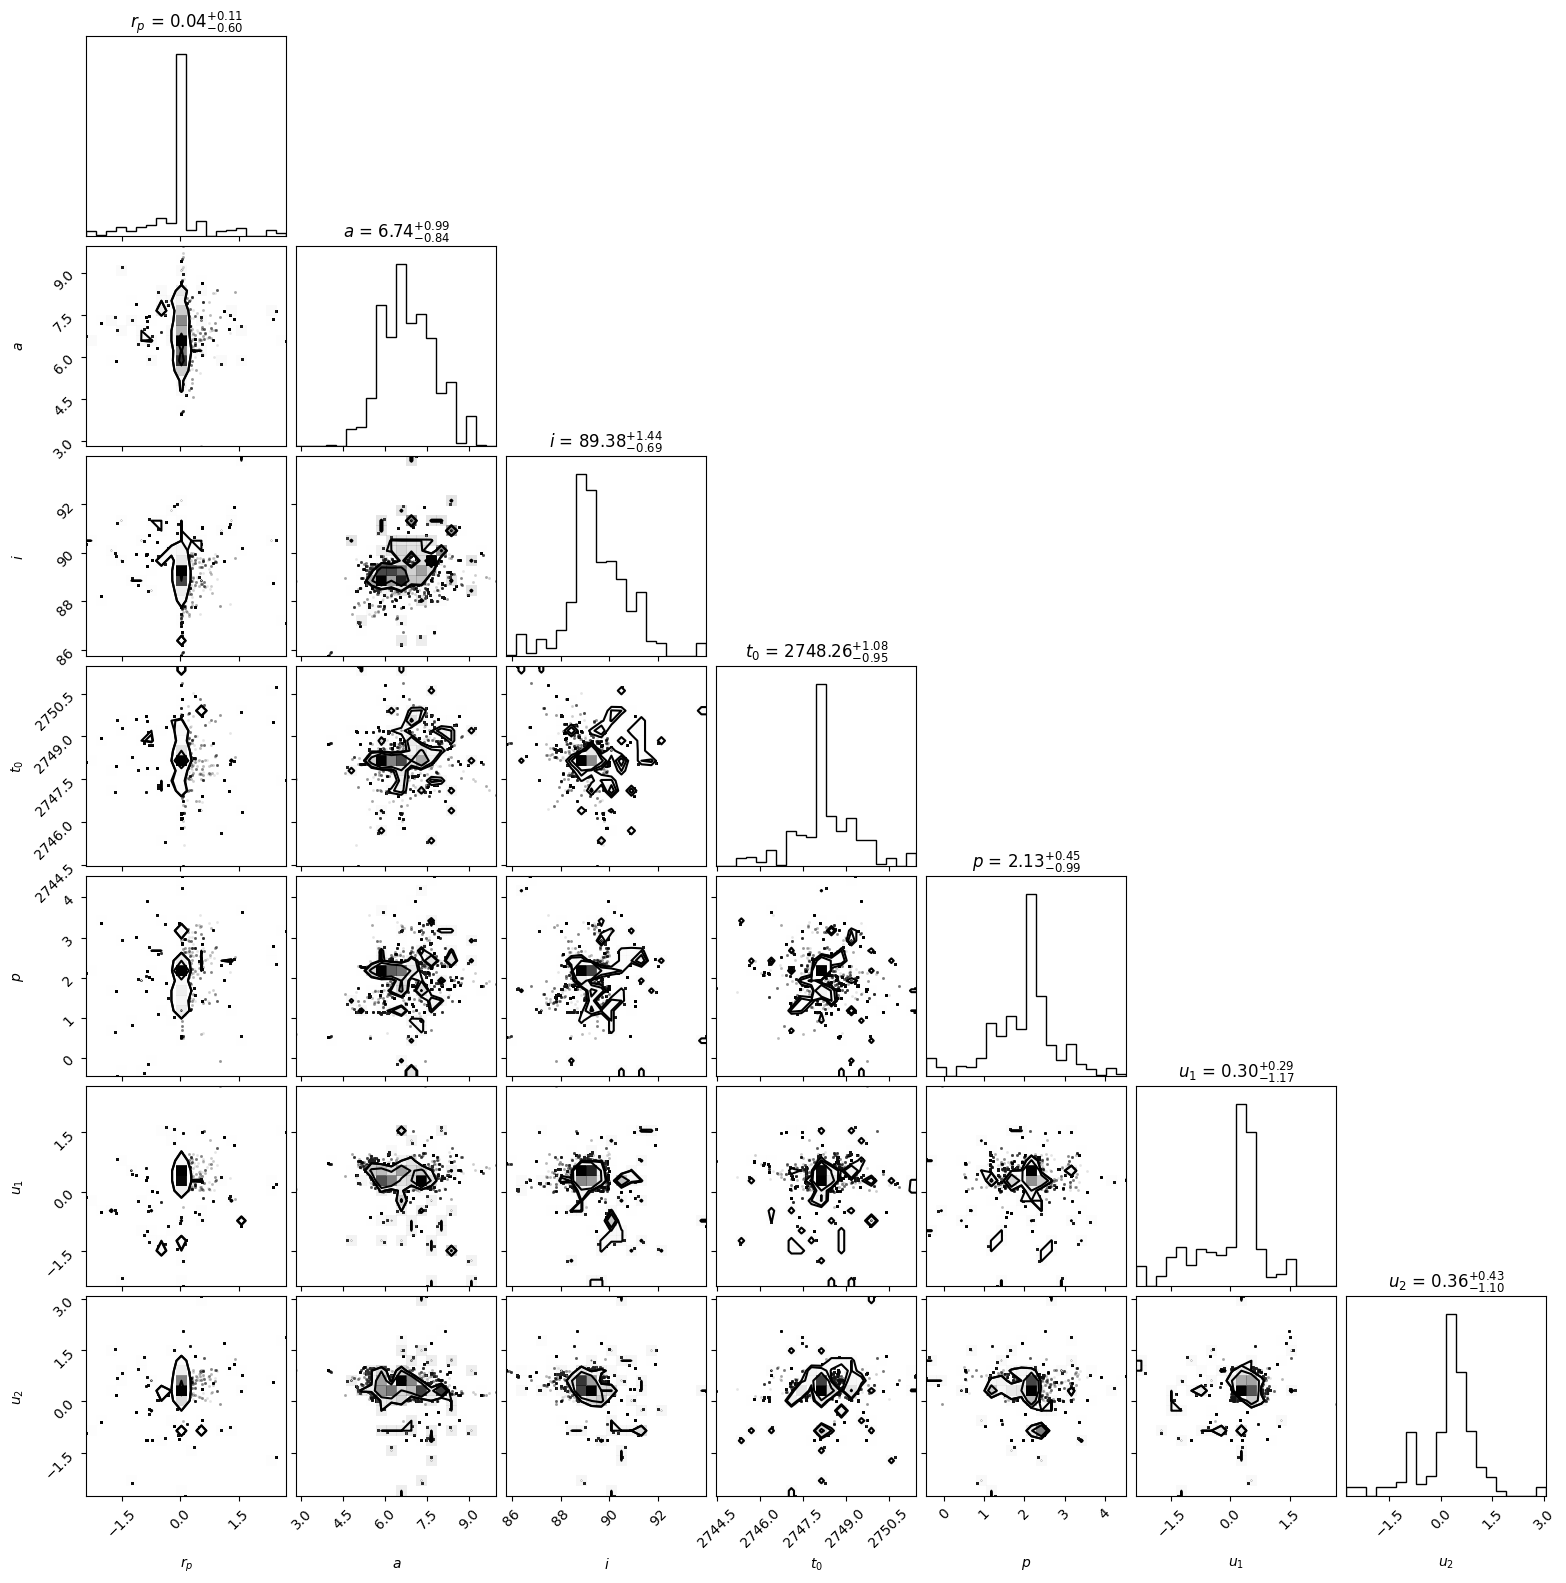

In [ ]:
import corner

fig = corner.corner(sampler.get_chain(),
                    labels=param_names,
                    show_titles=True,
                    title_quantiles=[0.16, 0.5, 0.84])